In [14]:
from __future__ import division

import warnings
from collections import namedtuple
import torch
import torch.nn as nn
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
import os
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.datasets as dset
import torch.utils.data as data
from ipywidgets import IntProgress
from torchvision import transforms

In [15]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = 'cpu'

print(device)

cuda


## Hyperparameters

In [16]:
LRATE = 0.01
EPOCHS = 50
trainBatchSize = 20
testBatchSize = 20

## Image Processing

In [17]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

## Download and prepare data with transforms

In [18]:
train_set = dset.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = data.DataLoader(dataset=train_set, batch_size=trainBatchSize, shuffle=True)
test_set = dset.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = data.DataLoader(dataset=test_set, batch_size=testBatchSize, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Inception module with dimension reductions
1. Create a python class called Inception which inherits nn.module

2. Create a init function to init this python class
    1. Require in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x and pool_planes 7 arguments.
    
    2. There are 4 Sequential blocks: b1,b2,b3,b4
    
    3. b1 is a block that consists of 2D convolution, a 2D batch normalization layer and a ReLU activation function
    
    4. b2 is a block that consists of two 2D convolutions, two 2D batch normalization layers and two ReLU activation functions
    
    5. b3 is a block that consists of two 2D convolutions, two 2D batch normalization layers and two ReLU activation functions
    
    6. b4 is a block consists of a Maxpooling layer, a 2D convolution, a 2D batch normalization layer and a ReLU activation function
    
3. Create the forward function: the forward function will forward the input function though every block and return the concatenation of all the output.

In [19]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True)
        )


        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=5, padding=2),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )
         

        # 3x3 max pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, padding=1, stride=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True)
        )
       

    def forward(self, x):
        out1 = self.b1(x)
        out2 = self.b2(x)
        out3 = self.b3(x)
        out4 = self.b4(x)
        return torch.cat([out1, out2, out3, out4], dim=1)

## GoogLeNet

In [20]:
class GoogLeNet(nn.Module):
    def __init__(self, n_classes):
        super(GoogLeNet, self).__init__()

        # 7x7 Conv -> MaxPool -> 3x3 Conv -> MaxPool
        self.b1 = nn.Sequential(
            nn.Conv2d(3, 192, padding=1, kernel_size=3),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
            # nn.MaxPool2d(kernel_size=3, padding=1, stride=2),
            # nn.Conv2d(64, 192, padding=1, kernel_size=3, stride=1),
            # nn.BatchNorm2d(192),
            # nn.ReLU(True),
            # nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        )

        # 2 inceptions
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)

        # MaxPool
        self.b2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        )

        # 5 inceptions
        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)

        # MaxPool
        self.b3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        )

        # 2 inceptions
        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        # avg pool
        self.b4 = nn.Sequential(
            nn.AvgPool2d(kernel_size=8, stride=1, padding=0)
        )

        # dropout(40%)
        self.dropout = nn.Dropout(0.4)
        
        # linear fully connected layer
        self.fc = nn.Linear(1024, n_classes)
        
        # softmax
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        #print("Shape initially:", x.shape)
        x = self.b1(x)
        #print("Shape before 3a:", x.shape)
        # Inception modules 3
        x = self.inception3a(x)
        x = self.inception3b(x)

        #print("Shape before b2:", x.shape)
        x = self.b2(x)

        #print("Shape before 4a:", x.shape)
        # Inception modules 4
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)

        #print("Shape before b3:", x.shape)
        x = self.b3(x)

        #print("Shape before 5a:", x.shape)
        # Inception modules 5
        x = self.inception5a(x)
        x = self.inception5b(x)

        #print("Shape before AvgPool:", x.shape)

        # AvgPool
        x = self.b4(x)

        x = x.reshape(x.shape[0], -1)
        #x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        #x = self.softmax(x)

        return x
        

## Create the network and send it to the target device

In [21]:
NUM_CLASSES = 10
GNET = GoogLeNet(NUM_CLASSES)

if torch.cuda.is_available():
    device = torch.device('cuda')
    GNET = GNET.to(device)
    print("Moved to gpu")
else:
    print("GPU unavailable")

Moved to gpu


## Creating an optimizer, criterion, and a scheduler

In [22]:
# Optimizer (Adam)
optimizer = torch.optim.Adam(GNET.parameters(), lr=LRATE)

# Criterion
criterion = nn.CrossEntropyLoss()

# Scheduler
milestones = [50, 99]
gamma = 0.5
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = milestones, gamma = gamma)


# Training
Then, we are going to train our Network

1. Set our network to the training mode.
2. Initialize the train loss, total data size, and number corrected predictions. 
3. For each data in the training split
    1. Put the data to the correct devices using .to()
    2. Reset the gradient of the optimzier.
    3. Feed the data forward to the google net
    4. Use the criterion function to compute the loss term
    5. Backpropagate the loss
    6. Update the network parameters using the optimizier
    7. Accumulate the training loss
    8. Find the prediction. hint: using torch.max()
    9. Increment the total_data size
    10. Increment the corrected prediction
    11. Print log

In [23]:
def train(network, train_loader, optimizer, criterion, device):
    network.train()

    train_loss = 0
    total_data_size = 0
    correct_pred = 0

    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        res = network(x)
        loss = criterion(res,y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        idx, pred = torch.max(res, 1)
        total_data_size += y.size(0)
        correct_pred += (y == pred).sum().item()

    train_accuracy = (correct_pred/total_data_size)*100
    print("Training accuracy:", train_accuracy, "Train loss:", train_loss)
    return train_accuracy, train_loss

#  Testing
Then, we are going to test our module

1. Set our network to the test model.
2. Initialize the test loss, total data size, and number corrected predictions. 
3. For each data in the training split, we warp it using torch.no_grad()
    1. Put the data to the correct devices using .to()
    2. Feed the data forward to the google net
    3. Use the criterion function to compute the loss term
    4. Accumulate the training loss
    5. Find the prediciton. hint: using torch.max()
    6. Increment the data size
    7. Increment the corrected prediction
    8. Print log

In [24]:
def test(network, test_loader, criterion, device):
    network.eval()

    test_loss = 0
    total_data_size = 0
    correct_pred = 0
    with torch.no_grad():
        for x,y in test_loader:
            x,y = x.to(device), y.to(device)
            res = network(x)
            loss = criterion(res, y)
            test_loss += loss.item()
            idx, pred = torch.max(res, 1)
            total_data_size += y.size(0)
            correct_pred += (y == pred).sum().item()

    test_accuracy = (correct_pred/total_data_size)*100
    print("Test accuracy:", test_accuracy, "Test loss:", test_loss)
    return test_accuracy, test_loss
    

##  Epochs:
For each epoch:
1. Step the scheduler
2. Train the model
3. Test our model
4. Update the accuracies
5. Save the module at the end and print the accuracy

In [25]:
test_losses = []
test_acc = []
train_losses = []
train_acc = []
device = torch.device('cuda')

for i in range(EPOCHS):
    scheduler.step()
    print("Epoch number:", i)
    train_accuracy, train_loss = train(GNET, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)

    test_accuracy, test_loss = test(GNET, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)
    

Epoch number: 0


/home/nyuad/anaconda3/envs/shawn_lab6/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Training accuracy: 36.562 Train loss: 4262.3775272369385
Test accuracy: 51.21 Test loss: 669.6089557409286
Epoch number: 1
Training accuracy: 60.099999999999994 Train loss: 2827.003587156534
Test accuracy: 68.8 Test loss: 436.1440104544163
Epoch number: 2
Training accuracy: 69.784 Train loss: 2203.3371872007847
Test accuracy: 73.47 Test loss: 378.9258994311094
Epoch number: 3
Training accuracy: 74.53800000000001 Train loss: 1843.0474043637514
Test accuracy: 74.22999999999999 Test loss: 375.66128328442574
Epoch number: 4
Training accuracy: 78.176 Train loss: 1605.4931134656072
Test accuracy: 80.75 Test loss: 282.68813698738813
Epoch number: 5
Training accuracy: 80.634 Train loss: 1428.807692028582
Test accuracy: 81.26 Test loss: 276.52149710059166
Epoch number: 6
Training accuracy: 82.64399999999999 Train loss: 1283.4438173249364
Test accuracy: 82.67 Test loss: 255.99376987665892
Epoch number: 7
Training accuracy: 84.06400000000001 Train loss: 1169.861154511571
Test accuracy: 84.1799999

In [28]:
print("Final Training Accuracy:", train_acc[-1])
print("Final Testing Accuracy:", test_acc[-1])

Final Training Accuracy: 98.732
Final Testing Accuracy: 91.03999999999999


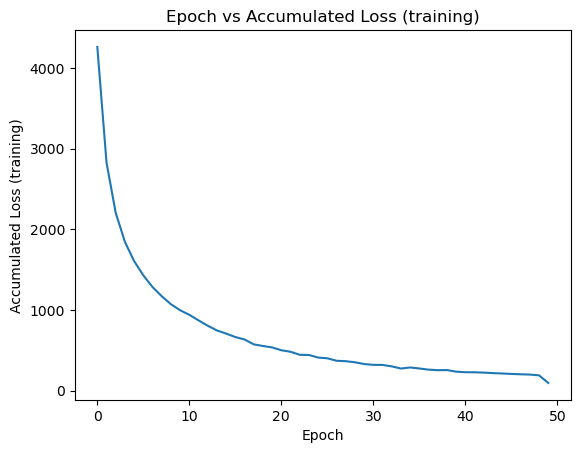

In [26]:
import matplotlib.pyplot as plt

# Plot epoch number vs accumulated loss for each epoch
plt.plot(range(0, EPOCHS), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Accumulated Loss (training)")
plt.title("Epoch vs Accumulated Loss (training)")
plt.show()

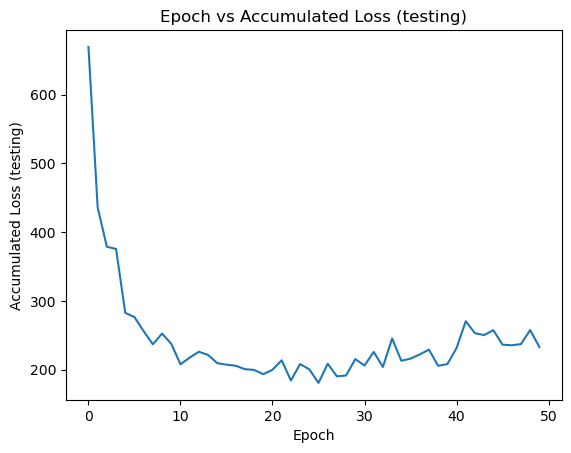

In [27]:
# Plot epoch number vs accumulated loss for each epoch
plt.plot(range(0, EPOCHS), test_losses)
plt.xlabel("Epoch")
plt.ylabel("Accumulated Loss (testing)")
plt.title("Epoch vs Accumulated Loss (testing)")
plt.show()